# Predicting Medical Insurance Costs Using Personal Health & Telehealth Data

### Modeling

For our initial modeling:
- We selected a Random Forest Regressor as a baseline due to its robustness and ability to handle both linear and non-linear relationships.
- The dataset was split into training (80%) and testing (20%) subsets.
- Performance was evaluated using MAE, RMSE, and R² score.
This baseline gives us a benchmark to improve upon using hyperparameter tuning and model explainability tools like SHAP.

## Random Forest Model


Model Evaluation:
MAE: 1774.63
RMSE: 2751.09
R^2 Score: 0.81


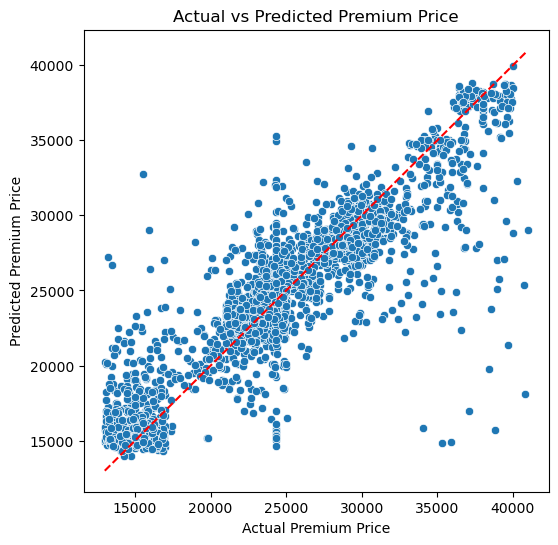

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature matrix and target variable
X = df.drop(columns=['premium_price'])
y = df['premium_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train baseline model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {mse**0.5:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Plot predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Premium Price")
plt.ylabel("Predicted Premium Price")
plt.title("Actual vs Predicted Premium Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

## XGBoost Model

In [51]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature engineering: BMI and interaction term
df['BMI'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
df['diabetes_telehealth'] = df['has_diabetes'] * df['Telehealth_Usage_Pct']

# Features and target
X = df.drop(columns=['premium_price'])
y = df['premium_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


XGBoost Results:
MAE: 1917.70
RMSE: 2917.24
R² Score: 0.78


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Lightgbm Model

In [65]:
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [67]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Feature engineering
df['BMI'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
df['diabetes_telehealth'] = df['has_diabetes'] * df['Telehealth_Usage_Pct']

# Define features and target
X = df.drop(columns=['premium_price'])
y = df['premium_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'verbose': -1,
    'seed': 42
}

# Train model
lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Predict
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_lgb)
rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)
r2 = r2_score(y_test, y_pred_lgb)

print("LightGBM Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


LightGBM Results:
MAE: 1911.81
RMSE: 2885.56
R² Score: 0.79


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## LightGBM Using HyperParameter Tuning Using GridSearchCV 

In [69]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Define new model (sklearn-compatible version for GridSearch)
lgb_estimator = LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=42)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'num_leaves': [31, 50, 100],
    'n_estimators': [100, 200]
}

# GridSearchCV setup
grid_search = GridSearchCV(estimator=lgb_estimator,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)

# Best model results
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = mean_squared_error(y_test, y_pred_tuned, squared=False)
r2 = r2_score(y_test, y_pred_tuned)

print("Tuned LightGBM Results:")
print("Best Parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] Start training from score 24405.686250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
print("Best Parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Best Parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 100}
MAE: 1844.48
RMSE: 2790.86
R² Score: 0.80


## SHAP Visualization

In [75]:
%pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 14.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [83]:
import shap

# For tree-based models like LightGBM or XGBoost
explainer = shap.Explainer(best_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)


100%|===================| 2996/3000 [00:24<00:00]        

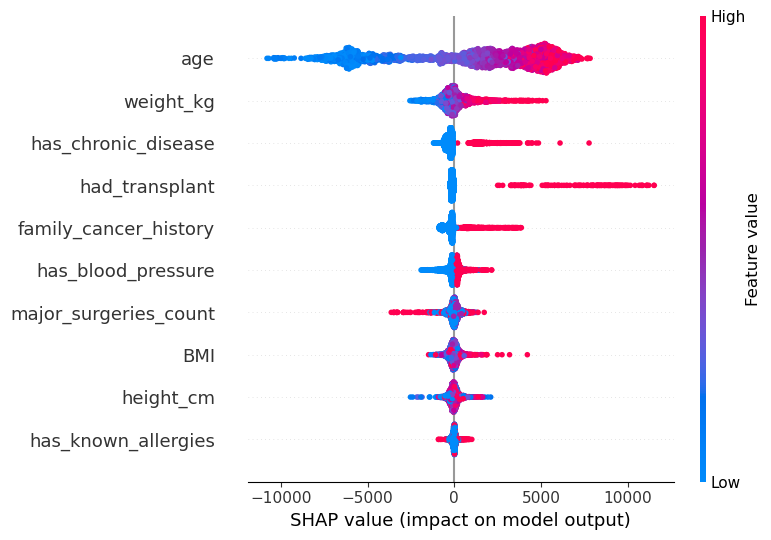

In [91]:
shap.summary_plot(shap_values.values, X_test, plot_type="dot", max_display=10)


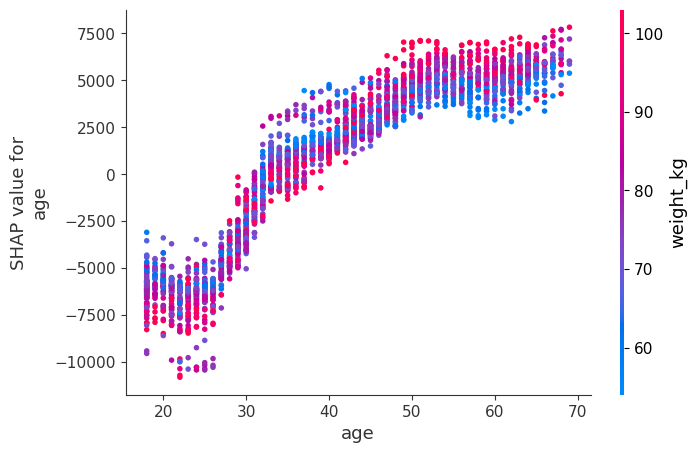

In [95]:
shap.dependence_plot("age", shap_values.values, X_test, interaction_index="weight_kg")


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


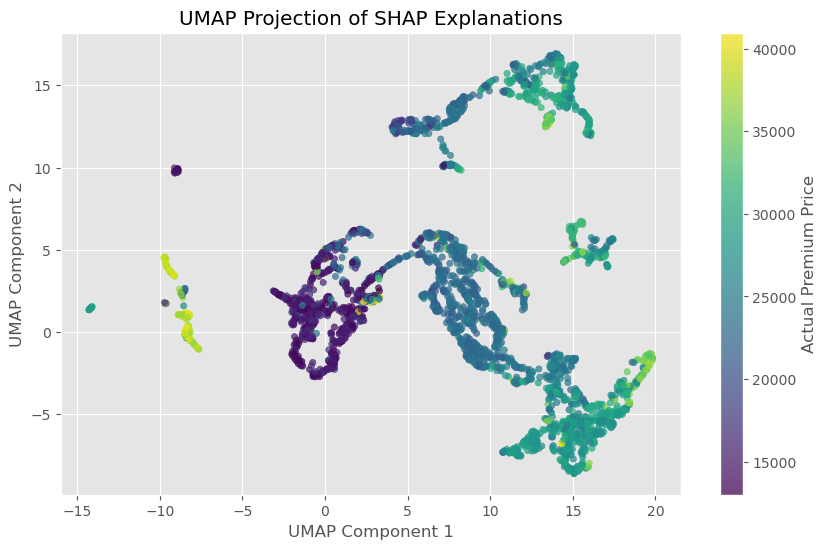

In [135]:
import umap
import matplotlib.pyplot as plt

# Step 1: Reduce SHAP values using UMAP
embedding = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42).fit_transform(shap_values.values)

# Step 2: Plot the embedding
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=y_test, cmap='viridis', s=20, alpha=0.7)
plt.colorbar(label="Actual Premium Price")
plt.title("UMAP Projection of SHAP Explanations")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()


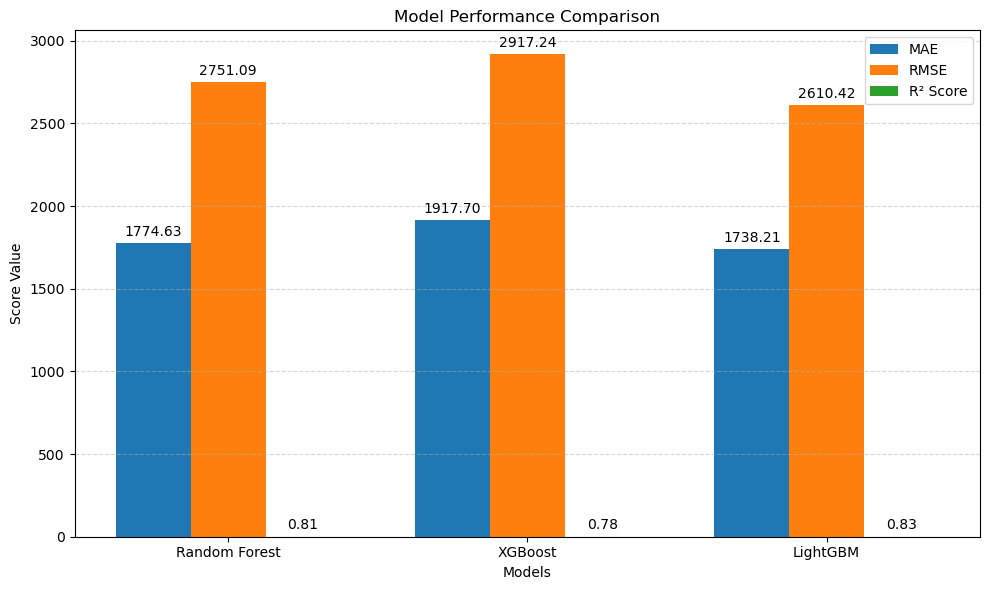

In [1]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'XGBoost', 'LightGBM']

# Replace these with your actual results
mae_scores = [1774.63, 1917.70, 1738.21]
rmse_scores = [2751.09, 2917.24, 2610.42]
r2_scores = [0.81, 0.78, 0.83]

x = np.arange(len(models))  
width = 0.25

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, mae_scores, width, label='MAE')
bar2 = ax.bar(x, rmse_scores, width, label='RMSE')
bar3 = ax.bar(x + width, r2_scores, width, label='R² Score')

# Labeling
ax.set_xlabel('Models')
ax.set_ylabel('Score Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bar1)
annotate_bars(bar2)
annotate_bars(bar3)

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()
